# 3.3 類似文章検索のファインチューニング

本ノートブックでは、JSTSデータセットを用いて、文章の類似度を計算するモデルをファインチューニングします。

モデルの評価は、Notebook「3-2_text_similarity_eval.ipynb」をご確認ください。

# 事前準備

ファインチューニングの準備として、ライブラリのインストールやデータセットの準備などを行います。

## (1)ライブラリのインストール

利用するライブラリをインストールします。

In [ ]:
! pip install datasets matplotlib japanize-matplotlib
! pip install fugashi unidic_lite
! pip install transformers
! pip install accelerate

## 乱数シードの設定

In [ ]:
from transformers.trainer_utils import set_seed

set_seed(2024)

## (2)データセットの準備

### データセットの読み込み

In [ ]:
from datasets import load_dataset

# データセットの読み込み
train_dataset = load_dataset(
    "shunk031/JGLUE", name="JSTS", split="train", trust_remote_code=True
    )

valid_dataset = load_dataset(
    "shunk031/JGLUE", name="JSTS", split="validation",trust_remote_code=True
    )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### データセットの概要を確認

In [ ]:
# データセットの概要を表示する
print('学習データ')
print(train_dataset)

print()

print('評価データ')
print(valid_dataset)

学習データ
Dataset({
    features: ['sentence_pair_id', 'yjcaptions_id', 'sentence1', 'sentence2', 'label'],
    num_rows: 12451
})

評価データ
Dataset({
    features: ['sentence_pair_id', 'yjcaptions_id', 'sentence1', 'sentence2', 'label'],
    num_rows: 1457
})


### データセットの中身を確認

In [ ]:
from pprint import pprint

# データセットの中身を確認する
print("学習データ")
pprint(train_dataset[0])

print()

print("評価データ")
pprint(valid_dataset[0])

学習データ
{'label': 0.0,
 'sentence1': '川べりでサーフボードを持った人たちがいます。',
 'sentence2': 'トイレの壁に黒いタオルがかけられています。',
 'sentence_pair_id': '0',
 'yjcaptions_id': '10005_480798-10996-92616'}

評価データ
{'label': 0.0,
 'sentence1': 'レンガの建物の前を、乳母車を押した女性が歩いています。',
 'sentence2': '厩舎で馬と女性とが寄り添っています。',
 'sentence_pair_id': '0',
 'yjcaptions_id': '100312_421853-104611-31624'}


## (3)モデルの読み込み

類似度を計算する際に利用するモデルを準備します。

In [ ]:
from transformers import AutoModelForSequenceClassification

# モデルの読み込み
model = AutoModelForSequenceClassification.from_pretrained(
    "cl-tohoku/bert-base-japanese-v3",
    num_labels=1,
    problem_type="regression",
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-v3 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## (4)トークナイザの準備

テキストをトークンに分割するために、トークナイザを準備します。

In [ ]:
from transformers import AutoTokenizer

# モデルに対応したトークナイザの読み込み
tokenizer = AutoTokenizer.from_pretrained("cl-tohoku/bert-base-japanese-v3")

# トークナイザの種類の確認
print(tokenizer)

BertJapaneseTokenizer(name_or_path='cl-tohoku/bert-base-japanese-v3', vocab_size=32768, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


### トークンに分割し、トークンIDを付与

In [ ]:
from transformers import BatchEncoding

def tokenize_dataset(example: dict[str, str | int]) -> BatchEncoding:
    """文ペアをトークン化し、IDに変換"""
    example_output = tokenizer(
        example["sentence1"], example["sentence2"], max_length=512
    )

    example_output["labels"] = example["label"]
    return example_output

# トークン化の実行
tokenized_train_datasets = train_dataset.map(
    tokenize_dataset,
    remove_columns=train_dataset.column_names,
)
tokenized_valid_datasets = valid_dataset.map(
    tokenize_dataset,
    remove_columns=valid_dataset.column_names,
)

Parameter 'function'=<function tokenize_dataset at 0x7dbff8b21b40> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/12451 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Map:   0%|          | 0/1457 [00:00<?, ? examples/s]

### ミニバッチ構築

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## (5)データの確認

類似度毎の件数を可視化してみます。

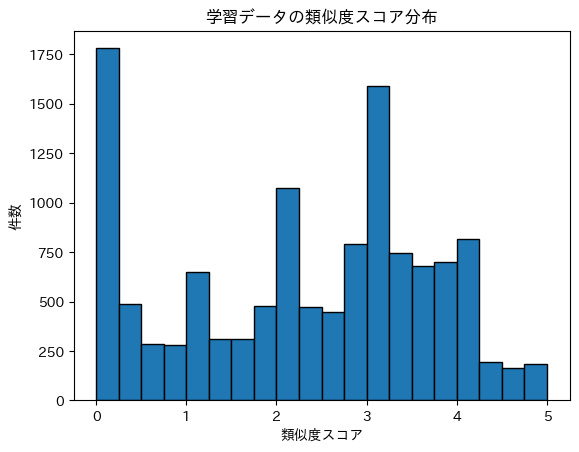

In [ ]:
import matplotlib.pyplot as plt
import japanize_matplotlib

scores = []
for data in train_dataset:
    scores.append(data["label"])

plt.hist(scores,bins=20,histtype="bar", edgecolor="black")
plt.title('学習データの類似度スコア分布')
plt.xlabel("類似度スコア")
plt.ylabel("件数")
plt.show()


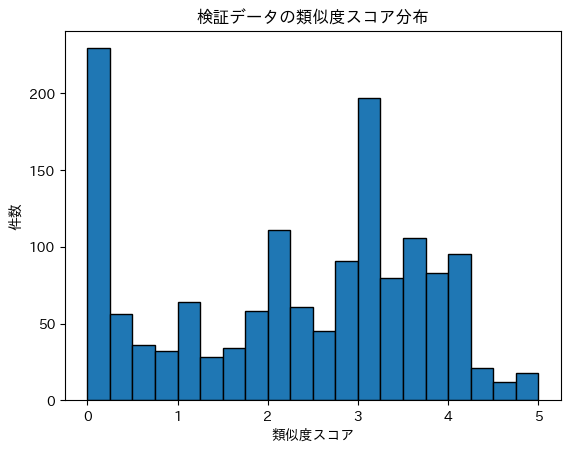

In [ ]:
import matplotlib.pyplot as plt
import japanize_matplotlib

scores = []
for data in valid_dataset:
    scores.append(data["label"])

plt.hist(scores,bins=20,histtype="bar", edgecolor="black")
plt.title('検証データの類似度スコア分布')
plt.xlabel("類似度スコア")
plt.ylabel("件数")
plt.show()


# ファインチューニングの実装

事前準備ができたので、モデルをファインチューニングします。

## (1)評価関数の定義

以下の関数にて、学習時に利用する評価指標の計算を行います。

In [ ]:
import numpy as np
from scipy.stats import pearsonr, spearmanr

def compute_metrics(
    eval_pred: tuple[np.ndarray, np.ndarray]
) -> dict[str, float]:
    """予測スコアと正解スコアを入力として、ピアソン、スピアマンの相関係数を算出"""
    predictions, labels = eval_pred
    predictions = predictions.squeeze(1)
    return {
        "pearsonr": pearsonr(predictions, labels).statistic,
        "spearmanr": spearmanr(predictions, labels).statistic,
    }

## (2)学習条件の設定

学習の条件を設定するため、`TrainingArguments`クラスに各種条件を指定します。

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="output_jsts",  # 結果の保存フォルダ
    num_train_epochs=3,  # 学習エポック数
    learning_rate=2e-5,  # 学習率
    lr_scheduler_type="linear",  # 学習率スケジューラの種類
    warmup_ratio=0.1,  # 学習率のウォームアップの長さを指定
    per_device_train_batch_size=32,  # 学習時のバッチサイズ
    per_device_eval_batch_size=32,  # 評価時のバッチサイズ
    save_strategy="epoch",  # モデルの保存タイミング
    logging_strategy="epoch",  # ログの出力タイミング
    evaluation_strategy="epoch",  # 評価のタイミング
    load_best_model_at_end=True,  # 最良のモデルを最後に読み込むかどうか
    metric_for_best_model="spearmanr",  # 最良のモデルを判断する指標
    fp16=True,  # 自動混合精度演算の有効化
    overwrite_output_dir=True,  # 出力先のディレクトリを上書きするかどうか
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## (3)ファインチューニングの実行

trainer.train() 関数を実行してファインチューニングを開始します。 Google Colab で T4 の GPU を選択した場合には約3分ほど時間がかかります。

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,  # 利用するモデル
    args=training_args,  # 学習時の設定
    train_dataset=tokenized_train_datasets,  # 学習データ
    eval_dataset=tokenized_valid_datasets,  # 評価データ
    data_collator=data_collator,  # データの前処理
    compute_metrics=compute_metrics,  # 評価指標の計算
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Pearsonr,Spearmanr
1,1.134900,0.374046,0.904713,0.862891
2,0.338300,0.387262,0.907830,0.870909
3,0.250400,0.338652,0.913993,0.874482


TrainOutput(global_step=1170, training_loss=0.5745594448513455, metrics={'train_runtime': 192.898, 'train_samples_per_second': 193.641, 'train_steps_per_second': 6.065, 'total_flos': 1013774752275654.0, 'train_loss': 0.5745594448513455, 'epoch': 3.0})

In [ ]:
# 評価指標の確認
eval_metrics = trainer.evaluate(tokenized_valid_datasets)

pprint(eval_metrics)

{'epoch': 3.0,
 'eval_loss': 0.33865225315093994,
 'eval_pearsonr': 0.9139927234170125,
 'eval_runtime': 1.3297,
 'eval_samples_per_second': 1095.705,
 'eval_spearmanr': 0.8744820951335042,
 'eval_steps_per_second': 34.593}


## (4)モデルの保存

次のコードを実行してファインチューニング済みのモデルを保存します。

In [ ]:
# 保存
trainer.save_state()  # 評価データのメトリクスの情報を保存
trainer.save_model()  # モデルの保存

# 以下のように保存先を引数として指定することも可能です。

# google driveに保存する例
# from google.colab import drive
# drive.mount("/content/drive")
# trainer.save_model("drive/MyDrive/output_jsts")

# 実行環境に保存する場合
# trainer.save_model("./output_jsts")